# DMS single protein subsampling strategies

Each position in a protein behaves kind of independently as far as predicting the mutation effect (having other positions in the same protein in training does not give rise to inflated performance, but having other mutations in the same position does). Because of this, I explore the sub-sampling strategy that can give the best results (reproduce the full mutational landscape) with least effort (number of measured mutations). I approach the problem as a simple Random search where the aa to use is one of the hyperparams.

## Load the training data

I use the save csv data from `dms_dataset_creation`.

In [5]:
import pandas as pd

df = pd.read_csv('/home/saul/master_thesis_work/dataset/dms/dms_training.csv')
df

/home/saul/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,protein,dms_id,uniprot_id,position,aa1,aa2,reported_fitness,pdb_id,pdb_chain,author_year,...,hmm_pssm_aa1_likelyhood,hmm_pssm_aa2_likelyhood,hmm_pssm_delta_likelyhood,tr_rosetta_feature_index,tr_rosetta_graph_closeness_centrality,tr_rosetta_graph_betweenness_centrality,tr_rosetta_graph_degree_centrality,tr_rosetta_graph_load_centrality,tr_rosetta_graph_harmonic_centrality,tr_rosetta_graph_clustering
0,TEM-1,beta-lactamase,P62593,20,P,P,0.581033,1btl,A,Firnberg2014,...,2.81126,2.81126,0.00000,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
1,TEM-1,beta-lactamase,P62593,20,P,Q,0.441480,1btl,A,Firnberg2014,...,2.81126,3.27353,0.46227,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
2,TEM-1,beta-lactamase,P62593,20,P,D,0.289750,1btl,A,Firnberg2014,...,2.81126,2.92236,0.11110,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
3,TEM-1,beta-lactamase,P62593,20,P,K,0.196582,1btl,A,Firnberg2014,...,2.81126,2.72602,-0.08524,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
4,TEM-1,beta-lactamase,P62593,20,P,N,0.053725,1btl,A,Firnberg2014,...,2.81126,3.00679,0.19553,19,0.150237,0.008805,0.021053,0.014844,0.53203,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21837,Yap65,WW_domain,P46937,203,R,C,-2.667780,4rex,A,Fowler2010,...,0.59945,5.62776,5.02831,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000
21838,Yap65,WW_domain,P46937,203,R,G,-2.731940,4rex,A,Fowler2010,...,0.59945,3.26877,2.66932,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000
21839,Yap65,WW_domain,P46937,203,R,D,-2.850370,4rex,A,Fowler2010,...,0.59945,3.95240,3.35295,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000
21840,Yap65,WW_domain,P46937,203,R,H,-3.011270,4rex,A,Fowler2010,...,0.59945,4.16162,3.56217,36,0.336134,0.011106,0.150000,0.010839,0.17050,0.800000


## Test training on all the possible single aa mutants

Serine is the most informative single mutation

In [115]:
import xgboost as xgb; xgb.set_config(verbosity=0)
from sklearn.model_selection import KFold
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.utils import shuffle
import random; random.seed(1)
import itertools
from tqdm.notebook import tqdm


def get_single_protein_model(x, y, xgb_params, feature_names):
    d_train = xgb.DMatrix(data=x, label=y, feature_names=feature_names)
    model = xgb.train(xgb_params, d_train, num_boost_round=xgb_params['num_rounds'])
    return model

def single_protein_model_test(model, x, y_true, feature_names):
    d_mat = xgb.DMatrix(data=x, feature_names=feature_names)
    y_pred = model.predict(d_mat)
    return stats.pearsonr(y_pred, y_true)[0]

def try_single_mutants(x, y, df, xbg_params, feature_names):
    aa_all = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    corr_df = pd.DataFrame(index=aa_all)
    for _,aa in enumerate(aa_all):
        for study in sorted(set(df.dms_id)):
            df_protein = df[df.dms_id == study].reset_index(drop=True)
            x_protein = x[df.dms_id == study]
            y_protein = y[df.dms_id == study]
            x_protein, y_protein, df_protein = shuffle(x_protein, y_protein, df_protein, random_state=1)
            train = (df_protein.aa2 == aa)
            val, test = next(KFold(n_splits=2).split(x_protein[~train]))
            model = get_single_protein_model(x_protein[train], y_protein[train], xgb_params, feature_names)
            corr_df.loc[aa,study] = single_protein_model_test(model, x_protein[val], y_protein[val], feature_names)
            
    return corr_df

In [ ]:
xgb_params_list = {
    'max_depth':[4, 6, 8],
    'min_child_weight':[0, 0.5, 1],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.1, 0.5],
    'gamma': [0],
    'eta': [1e-3, 1e-2],
    'tree_method':['hist'],
    'objective':['reg:squarederror'],
    'nthread':[25],
    'lambda':[1], # L2 regularization
    'alpha':[0], # L1 regularization
    'num_rounds':[500, 1000]
}
xgb_params_grid_search = [
    {key:param for key,param in zip(xgb_params_list,param_tuple)}
    for param_tuple in itertools.product(
        *xgb_params_list.values()
    )
]

features = [
    'aa1',
    'aa2',
    'ev_frequency',
    'ev_conservation',
    'ev_independent',
    'ev_epistatic',
    'netsurf_rsa',
    'netsurf_asa',
    'netsurf_p_q3_H','netsurf_p_q3_E','netsurf_p_q3_C',
    'netsurf_p_q8_G','netsurf_p_q8_H','netsurf_p_q8_I','netsurf_p_q8_B',
    'netsurf_p_q8_E','netsurf_p_q8_S','netsurf_p_q8_T','netsurf_p_q8_C',
    'netsurf_phi',
    'netsurf_psi',
    'netsurf_disorder',
    'hmm_pssm_A', 'hmm_pssm_C', 'hmm_pssm_D', 'hmm_pssm_E', 'hmm_pssm_F',
    'hmm_pssm_G', 'hmm_pssm_H', 'hmm_pssm_I', 'hmm_pssm_K', 'hmm_pssm_L',
    'hmm_pssm_M', 'hmm_pssm_N', 'hmm_pssm_P', 'hmm_pssm_Q', 'hmm_pssm_R',
    'hmm_pssm_S', 'hmm_pssm_T', 'hmm_pssm_V', 'hmm_pssm_W', 'hmm_pssm_Y',
    'hmm_pssm_aa1_likelyhood',
    'hmm_pssm_aa2_likelyhood',
    'hmm_pssm_delta_likelyhood',
    'tr_rosetta_graph_closeness_centrality',
    'tr_rosetta_graph_betweenness_centrality',
    'tr_rosetta_graph_degree_centrality',
    'tr_rosetta_graph_load_centrality',
    'tr_rosetta_graph_harmonic_centrality',
    'tr_rosetta_graph_clustering',
]

# get dummies is an amazing function that automagically converts to 1-hot what is needed
feature_df = pd.get_dummies(df[features])

print("Number of total param combinations:", len(xgb_params_grid_search))
xgb_params_random_search = random.sample(xgb_params_grid_search, 100)
x = feature_df.to_numpy(dtype='float')
y = df.reported_fitness.to_numpy(dtype='float')
feature_names = list(feature_df.columns)

corr_df = pd.DataFrame()
for i,xgb_params in tqdm(enumerate(xgb_params_random_search), total=len(xgb_params_random_search)):
    param_prefix = 'param_'+str(i)
    curr_corr_df = try_single_mutants(x, y, df, xgb_params, feature_names)
    curr_corr_df.rename((lambda index : param_prefix + '_' + str(index)), inplace=True)
    corr_df = pd.concat([corr_df, curr_corr_df])
corr_df.dropna(axis=0, inplace=True)
corr_df['average'] = corr_df.mean(axis=1)
corr_df['sem'] = corr_df.sem(axis=1)
corr_df.sort_values(by='average', axis=0, inplace=True, ascending=False)

<AxesSubplot:xlabel='variable', ylabel='count'>

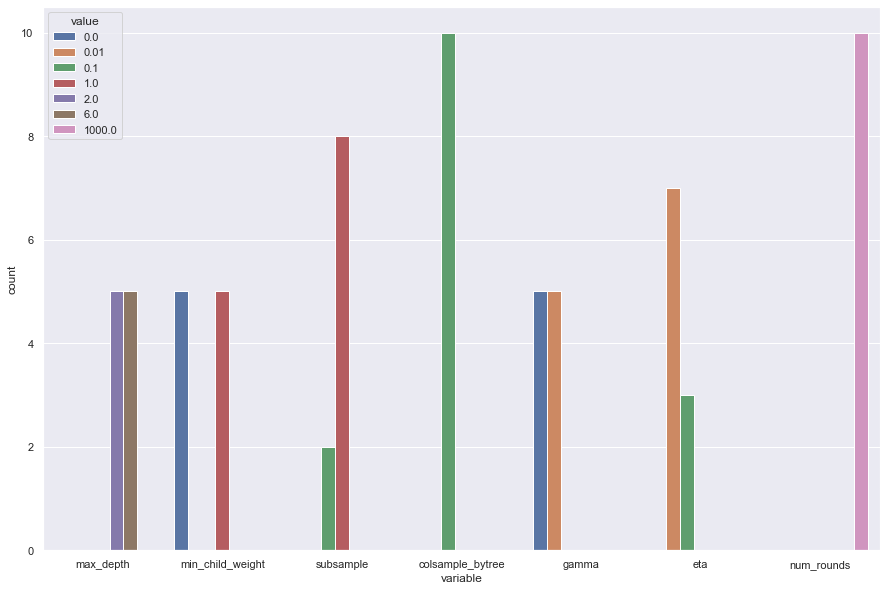

In [216]:
hyperparam_df = pd.DataFrame()
for name in corr_df.iloc[:10].index:
    param_index = int(name.split('_')[1])
    curr_params = pd.DataFrame(xgb_params_random_search[param_index], index=[param_index])
    hyperparam_df = hyperparam_df.append(curr_params)
hyperparam_df.drop(['objective', 'tree_method', 'nthread', 'alpha', 'lambda'], axis=1, inplace=True)

plt.figure(figsize=(15,10))
sns.countplot(data=hyperparam_df.melt(), x='variable', hue='value')

<AxesSubplot:>

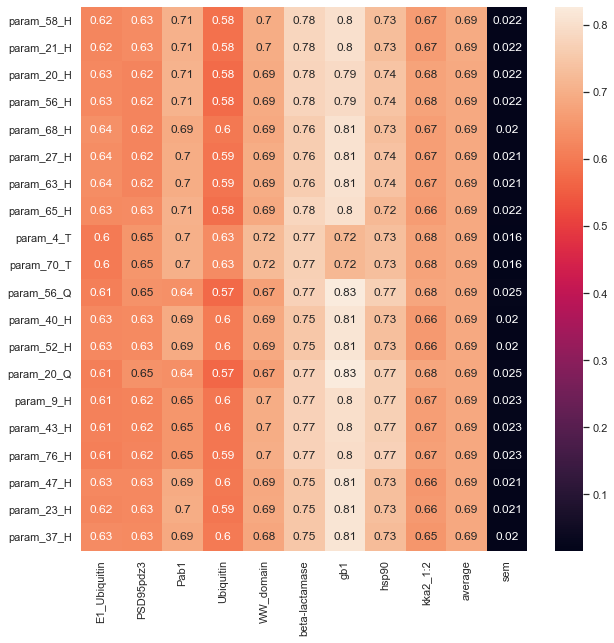

In [131]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_df.iloc[:20], annot=True)

## Training on 2 aminoacid mutants

Processing ('A', 'C')
Processing ('A', 'D')
Processing ('A', 'E')
Processing ('A', 'F')
Processing ('A', 'G')
Processing ('A', 'H')
Processing ('A', 'I')
Processing ('A', 'K')
Processing ('A', 'L')
Processing ('A', 'M')
Processing ('A', 'N')
Processing ('A', 'P')
Processing ('A', 'Q')
Processing ('A', 'R')
Processing ('A', 'S')
Processing ('A', 'T')
Processing ('A', 'V')
Processing ('A', 'W')
Processing ('A', 'Y')
Processing ('C', 'D')
Processing ('C', 'E')
Processing ('C', 'F')
Processing ('C', 'G')
Processing ('C', 'H')
Processing ('C', 'I')
Processing ('C', 'K')
Processing ('C', 'L')
Processing ('C', 'M')
Processing ('C', 'N')
Processing ('C', 'P')
Processing ('C', 'Q')
Processing ('C', 'R')
Processing ('C', 'S')
Processing ('C', 'T')
Processing ('C', 'V')
Processing ('C', 'W')
Processing ('C', 'Y')
Processing ('D', 'E')
Processing ('D', 'F')
Processing ('D', 'G')
Processing ('D', 'H')
Processing ('D', 'I')
Processing ('D', 'K')
Processing ('D', 'L')
Processing ('D', 'M')
Processing

<AxesSubplot:>

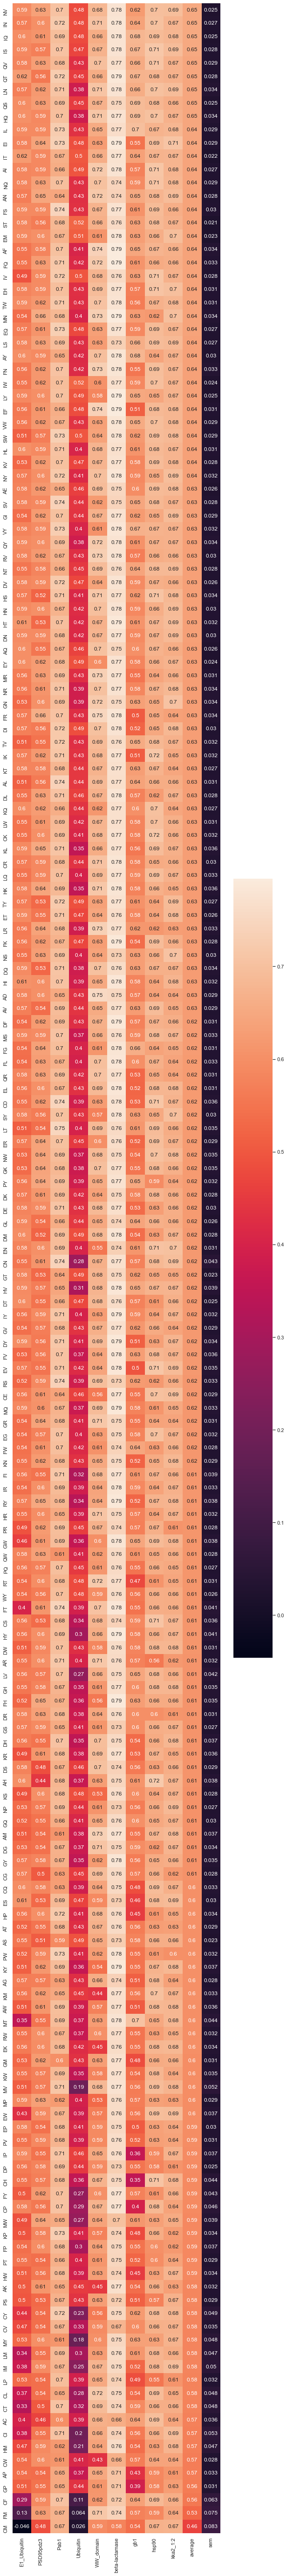

In [51]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.utils import shuffle
import itertools

def get_single_protein_model(x, y, xgb_params, num_rounds, feature_names):
    d_train = xgb.DMatrix(data=x, label=y, feature_names=feature_names)
    model = xgb.train(xgb_params, d_train, num_boost_round=num_rounds)
    return model

def single_protein_model_test(model, x, y_true, feature_names):
    d_mat = xgb.DMatrix(data=x, feature_names=feature_names)
    y_pred = model.predict(d_mat)
    return stats.pearsonr(y_pred, y_true)[0]

x = feature_df.to_numpy(dtype='float')
y = df.reported_fitness.to_numpy(dtype='float')
feature_names = list(feature_df.columns)


xgb_params = {'max_depth':6,
              'min_child_weight':1,
              'subsample': 0.1,
              'colsample_bytree': 1,
              'gamma': 0.1,
              'eta': 0.05,
              'tree_method':'hist',
              'objective':'reg:squarederror',
              'nthread':7,
              'lambda':0, # L2 regularization
              'alpha':0, # L1 regularization
             }
num_rounds = 50

aa_all = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
aa_2_combinations = itertools.combinations(aa_all, 2)

corr_df = pd.DataFrame()
for _,aa_comb in enumerate(aa_2_combinations):
    print('Processing', aa_comb)
    for study in sorted(set(df.dms_id)):
        df_protein = df[df.dms_id == study].reset_index(drop=True)
        x_protein = x[df.dms_id == study]
        y_protein = y[df.dms_id == study]
        x_protein, y_protein, df_protein = shuffle(x_protein, y_protein, df_protein, random_state=1)
        train = (df_protein.aa2.isin(aa_comb))
        val, test = next(KFold(n_splits=2).split(x_protein[~train]))
        model = get_single_protein_model(x_protein[train], y_protein[train], xgb_params, num_rounds, feature_names)
        aa_comb_label = "".join(aa_comb)
        corr_df.loc[aa_comb_label,study] = single_protein_model_test(model, x_protein[val], y_protein[val], feature_names)

corr_df['average'] = corr_df.mean(axis=1)
corr_df['sem'] = corr_df.sem(axis=1)
corr_df.sort_values(by='average', axis=0, inplace=True, ascending=False)

plt.close()
plt.figure(figsize=(10,100))
sns.heatmap(corr_df, annot=True)

### Explore a specific training strategy

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.utils import shuffle

def get_single_protein_model(x, y, xgb_params, num_rounds, feature_names):
    d_train = xgb.DMatrix(data=x, label=y, feature_names=feature_names)
    model = xgb.train(xgb_params, d_train, num_boost_round=num_rounds)
    return model

def single_protein_model_test(model, x, y_true, df, feature_names):
    is_wt = np.array(df.aa1 == df.aa2)
    d_mat = xgb.DMatrix(data=x, feature_names=feature_names)
    y_pred = model.predict(d_mat)
    print('Test performance for dataset:', study)
    print('test pearson:', stats.pearsonr(y_pred, y_true)[0])
    print('test spearman:', stats.spearmanr(y_pred, y_true)[0])
    print('test kendall:', stats.kendalltau(y_pred, y_true)[0])
    plt.close()
    sns.scatterplot(x=y_true[~is_wt],
                    y=y_pred[~is_wt],
                    marker='x')
    sns.scatterplot(x=y_true[is_wt],
                    y=y_pred[is_wt],
                    s=100,
                    alpha=0.5)
    plt.show()    

x = feature_df.to_numpy(dtype='float')
y = df.reported_fitness.to_numpy(dtype='float')
feature_names = list(feature_df.columns)


xgb_params = {'max_depth':6,
              'min_child_weight':1,
              'subsample': 0.1,
              'colsample_bytree': 1,
              'gamma': 0.1,
              'eta': 0.05,
              'tree_method':'hist',
              'objective':'reg:squarederror',
              'nthread':7,
              'lambda':0, # L2 regularization
              'alpha':0, # L1 regularization
             }
num_rounds = 50

aa_to_train_on = ['A']

for study in sorted(set(df.dms_id)):
    df_protein = df[df.dms_id == study].reset_index(drop=True)
    x_protein = x[df.dms_id == study]
    y_protein = y[df.dms_id == study]
    x_protein, y_protein, df_protein = shuffle(x_protein, y_protein, df_protein, random_state=1)
    train = (df_protein.aa2.isin(aa_to_train_on))
    val, test = next(KFold(n_splits=2).split(x_protein[~train]))
    print('Testing training on only mutants towards:', set(df_protein[train].aa2))
    print('Number of examples in training:', len(x_protein[train]),
          'validation:', len(x_protein[val]),
          'test:', len(x_protein[test]))
    print('Percentage of examples in training:', round(len(x_protein[train])/len(x_protein),2),
          'validation:', round(len(x_protein[val])/len(x_protein),2),
          'test:', round(len(x_protein[test])/len(x_protein),2))
    model = get_single_protein_model(x_protein[train], y_protein[train], xgb_params, num_rounds, feature_names)
    single_protein_model_test(model, x_protein[val], y_protein[val], df_protein.iloc[val], feature_names)
    #single_protein_model_test(model, x_protein[test], y_protein[test], df_protein.iloc[test], feature_names)